# AR(2) Signal with Filtered Observation and Additive White Noise

Here we import nessessary packages 

In [19]:
using Polynomials
using DSP
using Plots
pyplot()

include("..\\Matrix Wiener Filter\\wiener_filter_Matrix_fft.jl")


Crosscov (generic function with 2 methods)

The parameters for this model are defined here.

In [52]:
r, t = .5, 81

# each need modulus less than one for the process to be stationary. 
# Also for the process to be rea-valued r1 and r2 are either real or complex conjugates
r1, r2 = 0.3, -0.4 #r*exp(im*t), r*exp(im*t) 
w1, w2 = -0.1, 5
sig_v = 1.1
Sig_v = reshape([sig_v],1,1)

M_out = M_h = 20

20

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [53]:
poly = complex(ones(5))

poly[1] = ( w2 + sig_v^2*r1*r2 )/conj(w2 + sig_v^2*r1*r2);
poly[2] = ( w1 + w1*w2 - sig_v^2*(r1 + r2 + r1*r2*conj(r1+r2)) )/conj(w2 + sig_v^2*r1*r2);
poly[3] = ( 1 + w1^2 + w2^2 + sig_v^(2)(1 + abs(r1 + r2)^2 + abs(r1*r2)^2) )/conj(w2 + sig_v^2*r1*r2);
poly[4] = ( w1 + w1*w2 - sig_v^2*conj(r1 + r2 + r1*r2*conj(r1+r2)) )/conj(w2 + sig_v^2*r1*r2);
poly[5] = 1;
poly

rho_poly = Poly(poly)

Poly(1.0 - 0.101656092938947*x + 5.6079840536832455*x^2 - 0.101656092938947*x^3 + 1.0*x^4)

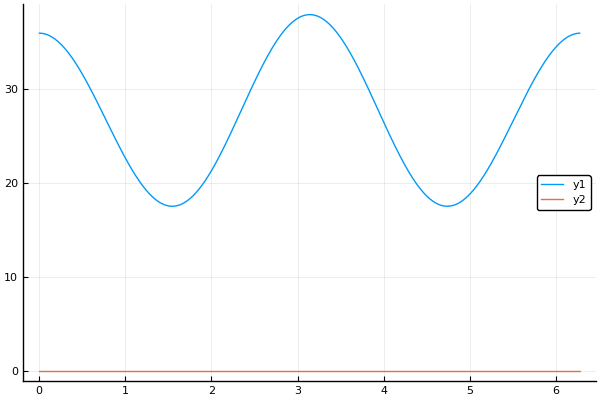

In [54]:
Nex = 1000;
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

numerator(z) = conj(w2 + sig_v^2*r1*r2)*rho_poly(z)/z^2;

plot(Theta,[real.(numerator.(Z)) imag.(numerator.(Z))])

In [55]:
rhos = roots(rho_poly)

abs.(rhos)

rho1, rho2 = rhos[ abs.(rhos) .< 1]

rho3, rho4 = [conj(rho1)^(-1); conj(rho2)^(-1)]

psi0 = conj(rho1*rho2/(w2 +r1*r2*sig_v^2));

alpha(n) = sum([rho1^(n-k)*rho2^k for k = 0:n]);
beta(n) = sum([r1^(n-k)*r2^k for k = 0:n]);

M_gam = 1000 + M_h + 2;

A = alpha.(0:M_gam);
B = beta.(0:M_gam);

gamma(n) = sum([conj(A[k])*B[k+n] for k = 1:1000]);

Gam = gamma.(0:M_h+2);

G = Gam[1:M_h+1] + w1*Gam[2:M_h+2] + w2*Gam[3:M_h+3]

Psi = psi0*conv(G,A[1:M_h+1]);

h_ana = [Psi[1], Psi[2] - Psi[1]*(r1+r2)];

h_temp = [Psi[n] - (r1 + r2)*Psi[n-1] + r1*r2*Psi[n-2] for n = 3 : M_h];

h_ana = [h_ana; h_temp]

20-element Array{Complex{Float64},1}:
   0.061408329737095424 - 1.2390727076824046e-18im
 -0.0014568537228502295 + 9.521159187619445e-18im
  -0.011348416663741819 - 8.992869746417524e-19im
   8.905069543191737e-5 - 4.3479514782923984e-18im
  0.0020943644360444627 + 4.538120021643581e-19im
   1.672804957796138e-5 + 4.114910997833923e-19im
 -0.0003859926422631326 + 3.7537505025370254e-19im
  -9.194928871432025e-6 + 2.844257070925829e-18im
   7.104193422490112e-5 + 9.056469271943877e-19im
   2.820306460253934e-6 - 5.339653034215797e-19im
 -1.3057411221207762e-5 + 1.0285629255947164e-20im
  -7.268247246905019e-7 - 1.905186015218428e-19im
  2.3966348598824453e-6 - 4.122915219598783e-19im
  1.7198213303657572e-7 + 8.220687215743806e-19im
 -4.3928198558198893e-7 + 3.9622404797830815e-19im
   -3.86714891907301e-8 + 2.450634933879511e-18im
   8.040334953699086e-8 + 3.496693112255698e-19im
   8.404761705625449e-9 - 7.094267498884479e-19im
 -1.4695513743983215e-8 + 2.918760910259798e-19im
 -1.782

## Data and Numerical Solution

In [56]:
l = real.([1, -(r1 + r2), r1*r2]);
w = [1, w1, w2];

Here we generate the data

In [57]:
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard
p=2

noise_sig = randn(1,steps_tot)
sig = zeros(1,steps_tot);

sig[:,1:p] = noise_sig[:,1:p] 

for i = p+1 : steps_tot
    sig[:,i] = sum([l[j]*sig[:,i-j] for j = 1:p]) + noise_sig[:,i]
end

sig = sig[:,discard + 1 : steps_tot];

noise_pred = Sig_v*randn(1,steps)
pred = sig .+ noise_pred;

Now we call the program I wrote to Numerically solve the Weiner filter. 

In [58]:
sig

1×1000000 Array{Float64,2}:
 -1.96678e38  -2.14695e38  -2.34363e38  …  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf

In [39]:
h_num_fft = vector_wiener_predictor_fft(pred, sig, M_out);
h_num_fft

1×1×20 Array{Complex{Float64},3}:
[:, :, 1] =
 NaN + NaN*im

[:, :, 2] =
 NaN + NaN*im

[:, :, 3] =
 NaN + NaN*im

...

[:, :, 18] =
 NaN + NaN*im

[:, :, 19] =
 NaN + NaN*im

[:, :, 20] =
 NaN + NaN*im

Now to verify the preformance.

In [30]:
sig_hat_num_fft = zeros(1,steps)
sig_hat_ana = zeros(1,steps)
for i = 2:steps
    sig_hat_num_fft[:,i] = sum([real.(h_num_fft[:,:,k])*pred[:,i-k] for k = 1:min(i - 1,M_out)])
    sig_hat_ana[:,i] = sum([real.(h_ana[k+1])*pred[:,i-k] for k = 0:min(i - 1,M_h - 1)])
end

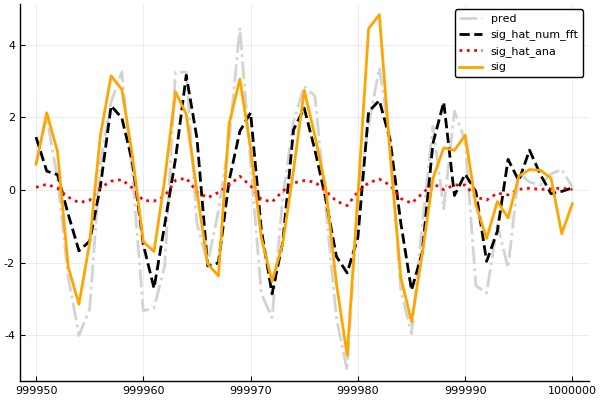

In [32]:
view = 50
start = steps - view
tim = start:start + view;

plot(tim,[pred[1,tim] sig_hat_num_fft[1,tim] sig_hat_ana[1,tim] sig[1,tim]],
    color=[:lightgrey :black :red :orange], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num_fft" "sig_hat_ana" "sig"])

In [14]:
error_num_fft = sig .-sig_hat_num_fft
error_ana = sig .-sig_hat_ana
lags = -5:10
C_ana = crosscov(error_ana,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)
plot(lags, [C_num_fft C_ana],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))

UndefVarError: UndefVarError: sig_hat_num_fft not defined

In [15]:
Nex = 1000;
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

S_sig_hat_num = z_crossspect(sig_hat_num,sig_hat_num,50; win = "Bart")

H(z) = sum([h_ana[i+1]*z^(-i) for i = 0 : M_h-1]);
S_pred(z) = (conj(w2 + r1*r2)*rho_poly(z)/z^2)/
    ((1-r1*z^(-1))*(1-r2*z^(-1))*(1-conj(r1)*z)*(1-conj(r2)*z));
S_sig_hat_ana(z) = H(z)*S_pred(z)*conj(H(conj(z)^(-1)));

plot(Theta,[real.(S_sig_hat_num.(Z)) real.(S_sig_hat_ana.(Z))],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["S_sig_hat_num" "S_sig_hat_ana"])

UndefVarError: UndefVarError: z_crossspect not defined